# Imports

In [246]:
import re
import itertools
import pandas as pd
import numpy as np
import fasttext, nltk   # NLP library
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

RAW_DATA_FOLDER = '../data/raw/'
PROCESSED_DATA_FOLDER = '../data/processed/'
DATASET = 'BeerAdvocate/'    # Can be either 'BeerAdvocate/' or 'RateBeer/'

# Load Data

In [190]:
reviews = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'reviews.pkl')
beers = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'beers.pkl')

# Make sure there are no duplicates on the primary key
reviews.drop_duplicates(subset=['beer_id', 'user_id', 'date'], inplace=True)
beers.drop_duplicates(subset=['beer_id'], inplace=True)

# Clean reviews

In [191]:
# TODO

# Group reviews by language

In [192]:
class LanguagePredictor:

    def __init__(self):
        pretrained_lang_model = "../src/lid.176.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text):
        predictions = self.model.predict(text)
        language = re.sub(pattern='__label__', repl='', string=predictions[0][0])
        score = predictions[1][0]
        return language, score

In [193]:
model = LanguagePredictor()
reviews['language'] = reviews.text.apply(lambda x: model.predict_lang(x)[0])
reviews['score_language'] = reviews.text.apply(lambda x: model.predict_lang(x)[1])
reviews.head()

,beer_id,user_id,date,text,language,score_language
0,142544,nmann08.184925,2015-08-20 10:00:00,"From a bottle, pours a piss yellow color with ...",en,0.891358
1,19590,stjamesgate.163714,2009-02-20 11:00:00,Pours pale copper with a thin head that quickl...,en,0.924852
2,19590,mdagnew.19527,2006-03-13 11:00:00,"500ml Bottle bought from The Vintage, Antrim.....",en,0.783006
3,19590,helloloser12345.10867,2004-12-01 11:00:00,Serving: 500ml brown bottlePour: Good head wit...,en,0.852789
4,19590,cypressbob.3708,2004-08-30 10:00:00,"500ml bottlePours with a light, slightly hazy ...",en,0.768192


In [194]:
reviews.groupby('language').text.count().sort_values(ascending=False)

language
en     2589044
fr         344
es          64
pt          40
fi          34
de          13
ja           9
it           7
cs           6
nl           5
ca           3
zh           3
pl           2
ru           2
sv           1
sh           1
tr           1
als          1
no           1
et           1
el           1
da           1
ceb          1
hr           1
Name: text, dtype: int64

The rest of the analysis will be done only on english reviews as there are not enough reviews for other language. Only reviews with a score language (confidence of the sentence belonging to the predicted language) greater or equal than 0.8 are considered

In [196]:
LANGUAGE = 'en'
reviews = reviews[(reviews.language == LANGUAGE) & (reviews.score_language >= 0.8)]

# Group reviews by beer style

In [197]:
merged = reviews.merge(beers, on='beer_id')[['text', 'style']]

In [198]:
merged.groupby('style').count().rename(columns={'text':'count'}).sort_values(by='count', ascending=False)

,count
style,
American IPA,244470
American Double / Imperial IPA,179626
American Double / Imperial Stout,116307
American Pale Ale (APA),104815
Russian Imperial Stout,79880
...,...
English Pale Mild Ale,1025
Faro,834
Roggenbier,824


In [199]:
df = merged[merged['style'] == 'American IPA']

# NLP

In [11]:
df['pos'] = df['text'].apply(nltk.word_tokenize)
df['pos'] = df['pos'].apply(nltk.pos_tag)

adjectives_IPA = list(df['pos'].explode().loc[lambda x: x.str[1] == 'JJ'].str[0].str.lower().values)
adjectives_counter = Counter(adjectives_IPA)

/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_6382/3173999396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['text'].apply(nltk.word_tokenize)
/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_6382/3173999396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['pos'].apply(nltk.pos_tag)


In [12]:
adjectives_counter.most_common()[:20]

[('good', 151547),
 ('nice', 141455),
 ('white', 89321),
 ('light', 83677),
 ('little', 77679),
 ('bitter', 68993),
 ('sweet', 63965),
 ('great', 56666),
 ('floral', 54346),
 ('hoppy', 50858),
 ('clear', 44891),
 ('dry', 44060),
 ('golden', 41378),
 ('tropical', 38802),
 ('fresh', 36601),
 ('much', 35718),
 ('big', 35698),
 ('strong', 33538),
 ('solid', 31063),
 ('slight', 30299)]

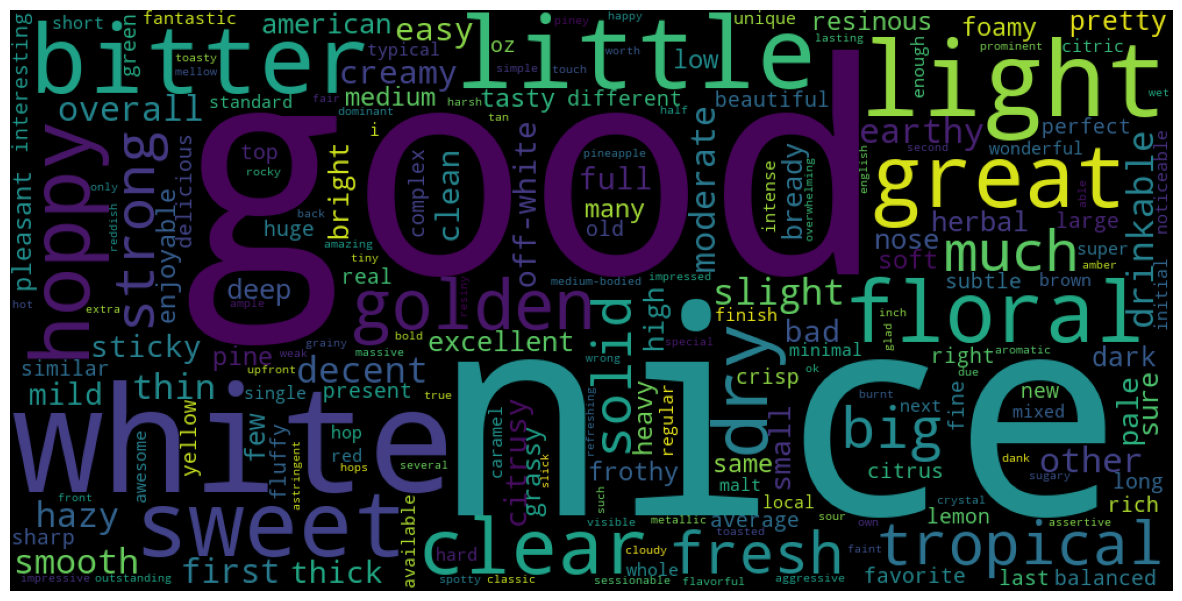

In [13]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(adjectives_counter)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [14]:
df = merged[merged['style'] == 'Russian Imperial Stout']

In [15]:
df['pos'] = df['text'].apply(nltk.word_tokenize)
df['pos'] = df['pos'].apply(nltk.pos_tag)

adjectives_stout = list(df['pos'].explode().loc[lambda x: x.str[1] == 'JJ'].str[0].str.lower().values)
adjectives_counter = Counter(adjectives_stout)

/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_6382/4114587886.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['text'].apply(nltk.word_tokenize)
/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_6382/4114587886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['pos'].apply(nltk.pos_tag)


In [16]:
adjectives_counter.most_common()[:20]

[('dark', 67713),
 ('black', 61026),
 ('good', 43720),
 ('nice', 38381),
 ('little', 30704),
 ('sweet', 27412),
 ('light', 22211),
 ('great', 19793),
 ('big', 19608),
 ('brown', 19601),
 ('bitter', 19087),
 ('rich', 18716),
 ('thick', 18514),
 ('creamy', 16941),
 ('full', 15344),
 ('much', 15327),
 ('smooth', 15014),
 ('strong', 14952),
 ('thin', 14489),
 ('roasted', 14416)]

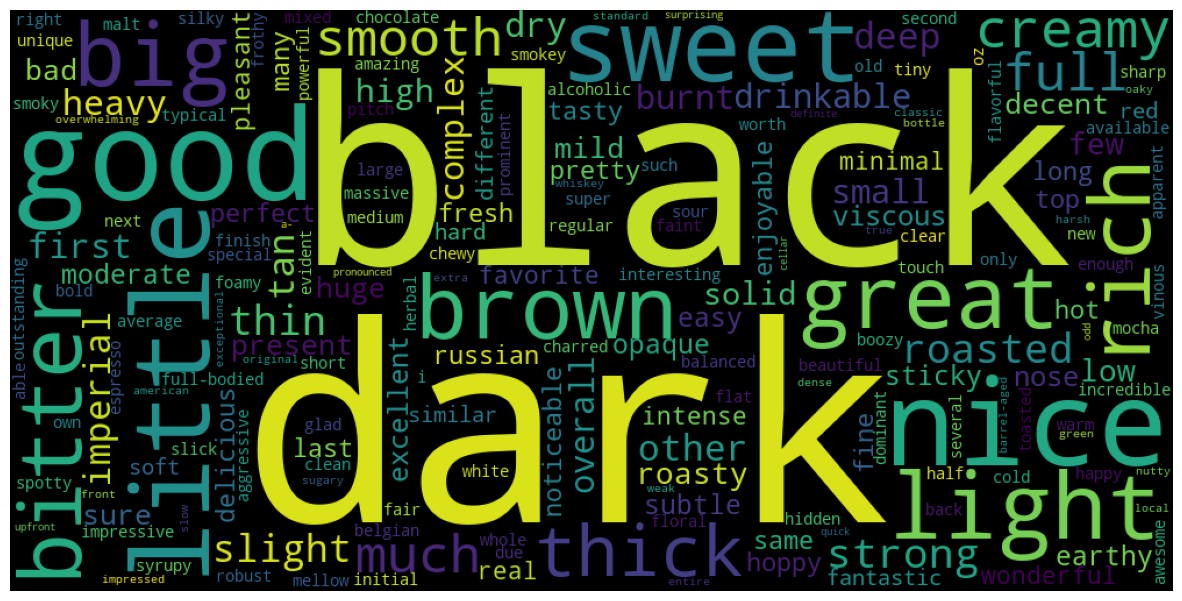

In [17]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(adjectives_counter)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### TF-IDF matrix

In [111]:
df = merged[merged['style'] == 'Happoshu']
df['pos'] = df['text'].apply(nltk.word_tokenize)
df['pos'] = df['pos'].apply(nltk.pos_tag)

adjectives_1 = list(df['pos'].explode().loc[lambda x: x.str[1] == 'JJ'].str[0].str.lower().values)
adj1 = ' '.join(adjectives_1)
adjectives_counter_1 = Counter(adjectives_1)
adjectives_counter_1.most_common()[0:10]

/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_8766/2649885718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['text'].apply(nltk.word_tokenize)
/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_8766/2649885718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['pos'].apply(nltk.pos_tag)


[('light', 235),
 ('sweet', 169),
 ('white', 146),
 ('good', 124),
 ('clear', 121),
 ('little', 110),
 ('bad', 102),
 ('thin', 80),
 ('japanese', 67),
 ('much', 67)]

In [112]:
df = merged[merged['style'] == 'Kvass']
df['pos'] = df['text'].apply(nltk.word_tokenize)
df['pos'] = df['pos'].apply(nltk.pos_tag)

adjectives_2 = list(df['pos'].explode().loc[lambda x: x.str[1] == 'JJ'].str[0].str.lower().values)
adj2 = ' '.join(adjectives_2)
adjectives_counter_2 = Counter(adjectives_2)
adjectives_counter_2.most_common()[0:10]

/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_8766/4044201853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['text'].apply(nltk.word_tokenize)
/var/folders/y_/y88txvzd6wn04_qgbshn3ct80000gn/T/ipykernel_8766/4044201853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'] = df['pos'].apply(nltk.pos_tag)


[('sweet', 340),
 ('light', 298),
 ('dark', 218),
 ('little', 199),
 ('good', 160),
 ('bready', 144),
 ('nice', 134),
 ('thin', 129),
 ('much', 122),
 ('first', 114)]

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
styles = []
corpus = []

for style, group in merged.groupby('style'):
    tagged_tok = nltk.pos_tag_sents(group['text'].apply(nltk.word_tokenize).tolist())
    adjectives = ' '.join([word for (word, tag) in list(itertools.chain.from_iterable(tagged_tok)) if tag == 'JJ'])
    styles.append(style)
    corpus.append(adjectives)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [94]:
inv_vocabulary = {v: k for k, v in vectorizer.vocabulary_.items()}

In [117]:
adj1 = [inv_vocabulary[i] for i in np.argsort(X.toarray()[0,:])[-10:]]
adj2 = [inv_vocabulary[i] for i in np.argsort(X.toarray()[1,:])[-10:]]